# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [44]:
# import libraries
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler
import pandas as pd

In [45]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Session1") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [46]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [47]:
print((df.count(), len(df.columns)))

(286500, 18)


In [48]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [49]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Check nulls in the dataset

In [50]:
def check_nulls(df):
    """Count nulls
    """
    check_nulls = [c[0] for c in df.dtypes if c[1] != 'boolean']
    null_df = df\
        .select([F.count(when(col(c).isNull(), c)).alias(c) for c in check_nulls])\
        .toPandas()\
        .T
    null_df.columns=["num"]
    nulls_names = null_df.num.to_dict()
    
    return nulls_names

In [51]:
check_nulls(df)

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

In [52]:
df.filter(df['userId']=='').count()

8346

In [53]:
df.select('registration').where(col('userId')=='').count()

8346

### There are 8k records which missing user information, since we are going to use user level info , hence we will drop these rows from analysis

In [54]:
df = df.filter(col("userId")!= '')

In [55]:
check_nulls(df)

{'artist': 50046,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 50046,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 50046,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

### Now we have removed rows which had missing user info which belonged to log out or guest auth type, the next task is to look at rows which have missing artist or song info

In [56]:
df.count()

278154

In [57]:
df.groupBy("auth").agg(F.count("registration")).show()

+---------+-------------------+
|     auth|count(registration)|
+---------+-------------------+
|Cancelled|                 52|
|Logged In|             278102|
+---------+-------------------+



In [58]:
df.where(F.col("artist").isNotNull()).groupBy('page').\
agg(F.count("userId")).show()

+--------+-------------+
|    page|count(userId)|
+--------+-------------+
|NextSong|       228108|
+--------+-------------+



### The null artist rows are distributed across various page where he user is not listeining to songs but performing other actions, hence we dont have to remove these rows

In [59]:
df.where(F.col("artist").isNull()).groupBy('page').\
agg(F.count("userId")).show()

+--------------------+-------------+
|                page|count(userId)|
+--------------------+-------------+
|              Cancel|           52|
|    Submit Downgrade|           63|
|         Thumbs Down|         2546|
|                Home|        10082|
|           Downgrade|         2055|
|         Roll Advert|         3933|
|              Logout|         3226|
|       Save Settings|          310|
|Cancellation Conf...|           52|
|               About|          495|
|            Settings|         1514|
|     Add to Playlist|         6526|
|          Add Friend|         4277|
|           Thumbs Up|        12551|
|                Help|         1454|
|             Upgrade|          499|
|               Error|          252|
|      Submit Upgrade|          159|
+--------------------+-------------+



### Some sessions have unusually high numbers of hit

In [60]:
session_max_item=df.groupBy('sessionId').\
agg(F.max("itemInSession")).toPandas()

In [61]:
# session_max_item

(array([  1.67500000e+03,   4.00000000e+02,   1.50000000e+02,
          5.20000000e+01,   2.60000000e+01,   6.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([    0. ,   132.1,   264.2,   396.3,   528.4,   660.5,   792.6,
          924.7,  1056.8,  1188.9,  1321. ]),
 <a list of 10 Patch objects>)

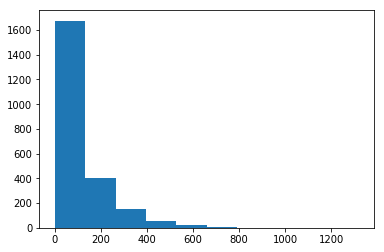

In [62]:
plt.hist(session_max_item['max(itemInSession)'])

### Lets see what are the mean and std deviation of numbers of items in a session

In [63]:
session_max_item['max(itemInSession)'].mean()

108.4757785467128

In [64]:
session_max_item['max(itemInSession)'].std()

123.76252480420017

### We will remove those rows which represent items 1  std. deviation away from the average number of items in a session, because it is unlikely that a particular uses will hit do so many actions in one session

In [65]:
outlier_tems=108+123

In [66]:
df_cleaned=df.filter(col('itemInSession')<=231)

In [67]:
df_cleaned.count()

238317

### The data is unique at user_id,sessionid and itemInSession level

In [68]:
df_cleaned.drop_duplicates(subset=['userId','sessionId','itemInSession']).count()

238317

In [69]:
w = Window.partitionBy('userId',"sessionId").orderBy('itemInSession')

In [70]:
df_cleaned=df_cleaned.withColumn('next_ts',
                        F.lead(df_cleaned['ts'])
                                 .over(w))



In [71]:
df_cleaned=df_cleaned.withColumn('item_duration',(col('next_ts')-col('ts'))/1000/60)

In [72]:
# df_cleaned.select('next_ts','ts','sessionId','itemInSession','item_duration').show()

#### Mean item duration is 3 mins and std dev is 2 min

In [73]:
df_cleaned.select(F.mean('item_duration')).show()

+------------------+
|avg(item_duration)|
+------------------+
| 3.448620047829462|
+------------------+



In [74]:
df_cleaned.select(F.stddev('item_duration')).show()

+--------------------------+
|stddev_samp(item_duration)|
+--------------------------+
|         2.198672307415625|
+--------------------------+



### Then we analyzed the mean time spent in each item in session

In [75]:
df_temp=df_cleaned.select('item_duration').toPandas()

In [76]:
df_temp=df_temp[df_temp['item_duration']>=0]

{'whiskers': [<matplotlib.lines.Line2D at 0x7feb1858a278>,
 'caps': [<matplotlib.lines.Line2D at 0x7feb1858ac18>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feb20987278>],
 'medians': [<matplotlib.lines.Line2D at 0x7feb1859a518>],
 'fliers': [<matplotlib.lines.Line2D at 0x7feb1859a978>],
 'means': []}

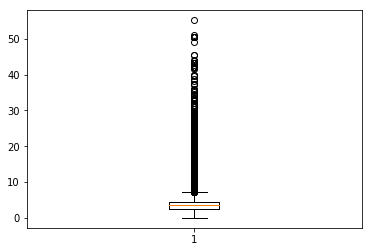

In [77]:
plt.boxplot(df_temp['item_duration'])

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Now lets create  a churn column

In [78]:
df_cleaned = df_cleaned.withColumn('churn_event', F.when(col('page')=='Cancellation Confirmation',1).otherwise(0))

### Now based on what is status of each user in their latest ts we

In [79]:
df_cleaned=df_cleaned.withColumn('has_the_user_churned',
               F.sum('churn_event')\
                    .over(Window\
                         .partitionBy('userId')\
                         .orderBy(F.desc('ts'))))

In [80]:
df_user_churn=df_cleaned.groupby('userId').agg(F.sum(col('churn_event')))

In [81]:
df_user_churn=df_user_churn.withColumn('user_churn',F.when(col('sum(churn_event)')>=1,1).otherwise(0))

In [82]:
df_user_churn.select('user_churn').agg(F.sum(col('user_churn'))).show()

+---------------+
|sum(user_churn)|
+---------------+
|             47|
+---------------+



In [83]:
df_user_churn.count()

225

In [84]:
df_cleaned_1=df_cleaned.join(df_user_churn,on=['userId'],how='left')

### Now that we have a churn column, lets analyze each user based on its churn flag

In [85]:
df1=df_cleaned_1.select('userId','user_churn','gender').drop_duplicates().toPandas()

In [86]:
def feature_bar(df, inputcol,target='user_churn'):
   
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    data = df.groupby([inputcol, 'user_churn']).size().unstack()
    print(data)
    data.plot(kind='bar', ax=ax)
    ax.set_ylabel('Count')
    plt.suptitle(f'{inputcol} by {target}')

In [87]:
print('Female Churned %',17/(17+87)*100)


Female Churned % 16.346153846153847


In [88]:
print('Male Churned %',30/(91+30)*100)

Male Churned % 24.793388429752067


user_churn   0   1
gender            
F           87  17
M           91  30


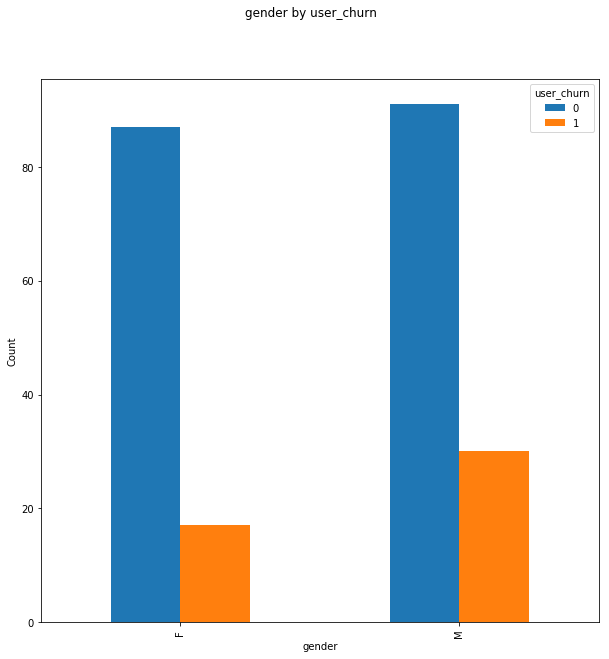

In [89]:
feature_bar(df1,'gender')

### This shows the 24% Males are churning against 16% males, hence gender can be an important factor in detrmining churn

In [90]:
df2=df_cleaned_1.select('userId','user_churn','page').toPandas()

user_churn                        0        1
page                                        
About                         364.0     40.0
Add Friend                   3175.0    491.0
Add to Playlist              4793.0    731.0
Cancel                          NaN     47.0
Cancellation Confirmation       NaN     47.0
Downgrade                    1486.0    240.0
Error                         200.0     25.0
Help                         1063.0    189.0
Home                         7602.0   1277.0
Logout                       2395.0    407.0
NextSong                   168114.0  26599.0
Roll Advert                  2941.0    880.0
Save Settings                 234.0     46.0
Settings                     1105.0    197.0
Submit Downgrade               47.0      9.0
Submit Upgrade                128.0     27.0
Thumbs Down                  1825.0    388.0
Thumbs Up                    9397.0   1323.0
Upgrade                       387.0     98.0


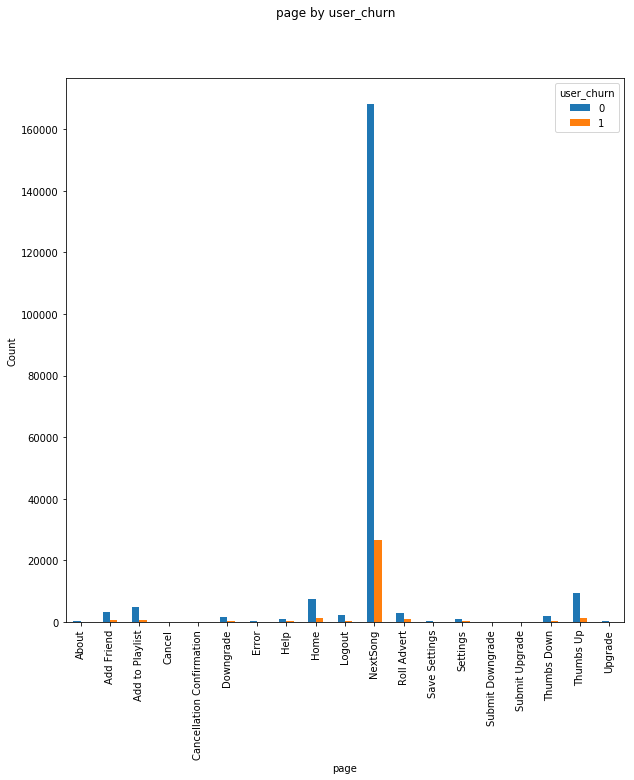

In [91]:
feature_bar(df2,'page')

#### The above plot is very crucial, it shows that the users who dont churn click on Next Song the most, they also add more friends, they add more songs to playlist, they give thumbs up/down to more songs- basically are proactively reviewing the application , they also browse the home page a lot

In [92]:
df_cleaned_1['item_duration']

Column<b'item_duration'>

In [93]:
df3=df_cleaned_1.filter(col('page')=='NextSong').groupBy('userId','user_churn','sessionId').agg(F.sum(col('item_duration'))).groupBy('user_churn').agg(F.avg(col('sum(item_duration)')).alias('Mean_session_Mins')).toPandas()

Text(0.5,1,'Mean Time Spent by the user who churned versus who did not churn')

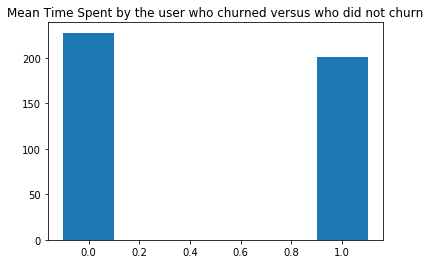

In [94]:
plt.bar(df3['user_churn'],df3['Mean_session_Mins'],width=0.2)
plt.title('Mean Time Spent by the user who churned versus who did not churn')

### From the plot we can see the users who churn on an average spend less time than those who did not

In [95]:
df4=df_cleaned_1.select('userId','user_churn','level').drop_duplicates().toPandas()

In [96]:
print('Free Users Churn %',41/(41+152)*100)

Free Users Churn % 21.243523316062177


In [97]:
print('Paid Users Churn %',31/(31+133)*100)

Paid Users Churn % 18.902439024390244


user_churn    0   1
level              
free        152  41
paid        133  31


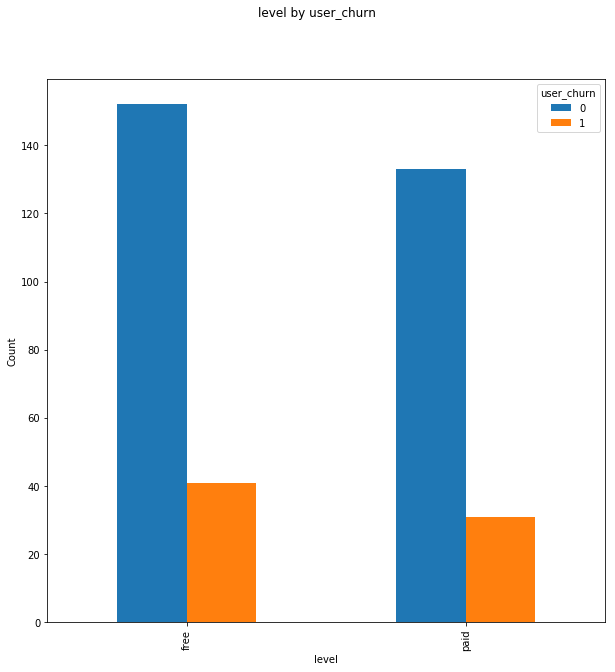

In [98]:
feature_bar(df4,'level')

### The above plot shows that free users have churned more (21%) as copared to paid user 18%

In [99]:
df5=df_cleaned_1.select('user_churn','method').toPandas()

In [100]:
df5.shape

(238317, 2)

In [101]:
2993/15148
# 30068/190108

0.19758383945075259

user_churn       0      1
method                   
GET          15148   2993
PUT         190108  30068


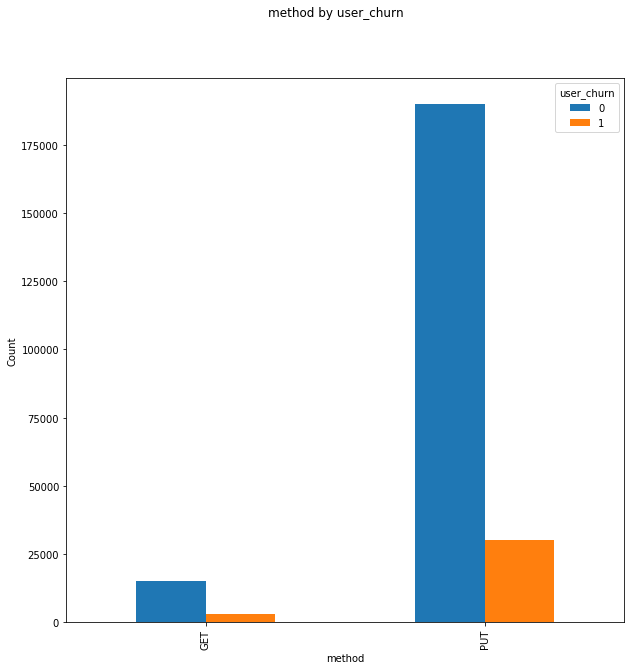

In [102]:
feature_bar(df5,'method')

### Churn rate is high in people using get method as compared to put

In [103]:
df6=df_cleaned_1.select('user_churn','userAgent').toPandas()

user_churn                                                0       1
userAgent                                                          
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) ...   1209.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) ...   5509.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...      NaN   187.0
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5)...    379.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5)...    573.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5)...    240.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5)...    235.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2)...    740.0  1638.0
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2)...    789.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2)...    310.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3)...   1710.0     NaN
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4)...    639.0   468.0
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4).

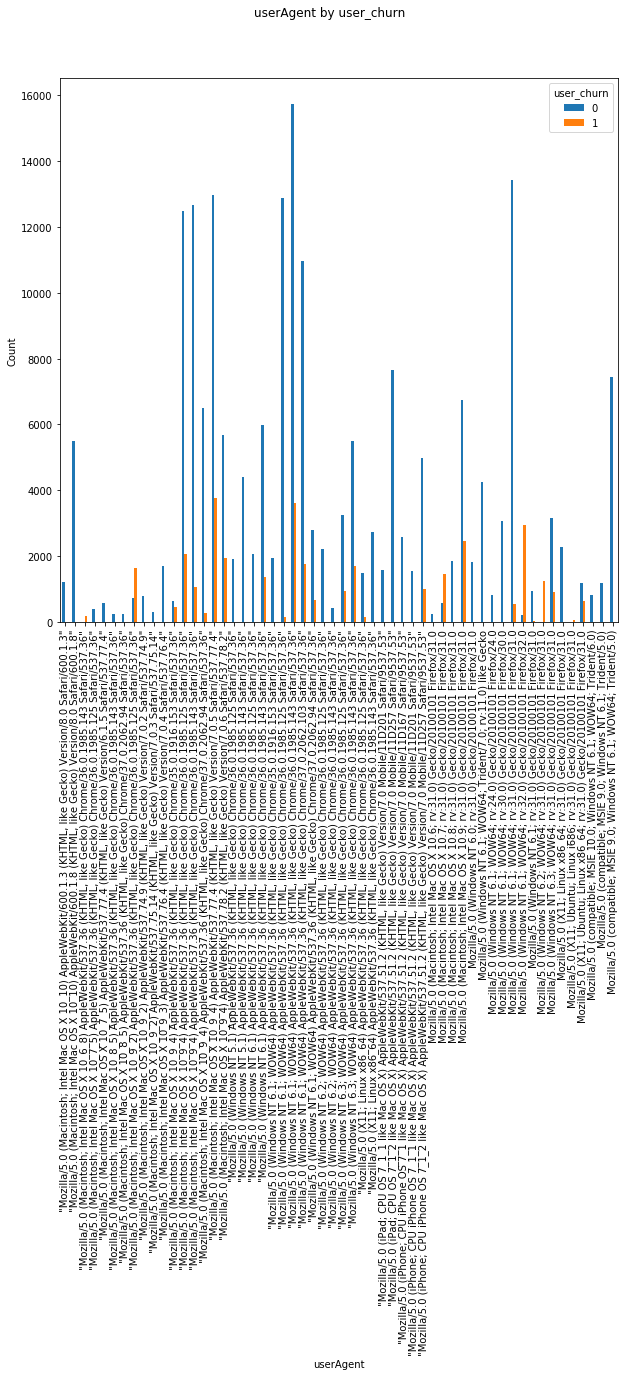

In [104]:
feature_bar(df6,'userAgent')

### Certain USer Agents have more percentage of people churning while others have less

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### User level features such as gender,level

In [105]:
f1= df_cleaned_1.select('userId','gender','level','user_churn').drop_duplicates()

### How long does a user spends on an item in a session

In [106]:
f2=df_cleaned_1.groupBy('userId','user_churn','sessionId').agg(F.sum(col('item_duration'))).groupBy('userId').agg(F.avg(col('sum(item_duration)')).alias('Mean_session_Mins'))

#### Number of artist listened per session

In [107]:
f3=df_cleaned_1.groupBy('userId','user_churn','sessionId').agg(F.countDistinct(col('artist'))).groupby('userId').agg(F.mean(col('count(DISTINCT artist)')).alias('Avg_artist_per_session'))

### How long does a session last on an average

In [108]:
f4=df_cleaned_1.groupBy('userId','sessionId').agg(F.sum(col('item_duration'))).groupby('userId').agg(F.mean(col('sum(item_duration)')).alias('Avg_session_mins'))

### How many times a user clicks on Next Song

In [109]:
f5=df_cleaned_1.filter(col('page')=='NextSong').groupBy('userId').agg(F.count(col('page')).alias('Next_Song_clicks'))

### How many times a user adds to playlist

In [110]:
f6=df_cleaned_1.filter(col('page')=='Add to Playlist').groupBy('userId').agg(F.count(col('page')).alias('Add_to_playlist_clicks'))

### How many times user clicks on Thumbs up

In [111]:
f7=df_cleaned_1.filter(col('page')=='Thumbs Up').groupBy('userId').agg(F.count(col('page')).alias('Thumbs_up_clicks'))

### How many time a user adds a friend

In [112]:
f8=df_cleaned_1.filter(col('page')=='Add Friend').groupBy('userId').agg(F.count(col('page')).alias('Add_Friend_clicks'))

### How many times user clicks on Thumbs Down

In [113]:
f9=df_cleaned_1.filter(col('page')=='Thumbs Down').groupBy('userId').agg(F.count(col('page')).alias('Thumbs_Down_clicks'))

#### Join all the feautures

In [114]:
master_data=f1.join(f2,on=['userId'],how='left').join(f3,on=['userId'],how='left').\
join(f4,on=['userId'],how='left').join(f5,on=['userId'],how='left').\
join(f6,on=['userId'],how='left').join(f7,on=['userId'],how='left').\
join(f8,on=['userId'],how='left').join(f9,on=['userId'],how='left')

In [115]:
check_nulls(master_data)

{'userId': 0,
 'gender': 0,
 'level': 0,
 'user_churn': 0,
 'Mean_session_Mins': 0,
 'Avg_artist_per_session': 0,
 'Avg_session_mins': 0,
 'Next_Song_clicks': 0,
 'Add_to_playlist_clicks': 10,
 'Thumbs_up_clicks': 5,
 'Add_Friend_clicks': 22,
 'Thumbs_Down_clicks': 23}

In [116]:
master_data=master_data.na.fill(0)

In [117]:
check_nulls(master_data)

{'userId': 0,
 'gender': 0,
 'level': 0,
 'user_churn': 0,
 'Mean_session_Mins': 0,
 'Avg_artist_per_session': 0,
 'Avg_session_mins': 0,
 'Next_Song_clicks': 0,
 'Add_to_playlist_clicks': 0,
 'Thumbs_up_clicks': 0,
 'Add_Friend_clicks': 0,
 'Thumbs_Down_clicks': 0}

## Lets convert String column to integer

In [118]:
master_data=master_data.withColumn('gender',F.when(col('gender')=='F',1).otherwise(0))

In [119]:
master_data=master_data.withColumn('level',F.when(col('level')=='free',1).otherwise(0))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Splitting the master data in train & test

In [120]:
from pyspark.sql.types import DoubleType
master_data = master_data.withColumn("label", master_data.user_churn.cast(DoubleType()))

In [121]:
train_df, test_df , val_df= master_data.randomSplit([0.8, 0.1,0.1], seed=2)

In [130]:
train_df.select('user_churn').agg(F.sum(col('user_churn'))).show()

+---------------+
|sum(user_churn)|
+---------------+
|             64|
+---------------+



### Transforming input columns user vector assembler

In [131]:
input_cols =['gender',
 'level',
 'Mean_session_Mins',
 'Avg_artist_per_session',
 'Avg_session_mins',
 'Next_Song_clicks',
 'Add_to_playlist_clicks',
 'Thumbs_up_clicks',
 'Add_Friend_clicks',
 'Thumbs_Down_clicks']

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")

In [132]:
pipeline_lr = Pipeline(stages=[assembler, scalar])
pipe_model = pipeline_lr.fit(train_df)

In [134]:
train_transform = pipe_model.transform(train_df)
test_transform = pipe_model.transform(test_df)
val_transform = pipe_model.transform(val_df)

In [135]:
train_transform.persist()
test_transform.persist()
val_transform.persist()

DataFrame[userId: string, gender: int, level: int, user_churn: int, Mean_session_Mins: double, Avg_artist_per_session: double, Avg_session_mins: double, Next_Song_clicks: bigint, Add_to_playlist_clicks: bigint, Thumbs_up_clicks: bigint, Add_Friend_clicks: bigint, Thumbs_Down_clicks: bigint, label: double, features: vector, scaled_features: vector]

### Logistic Regression

In [136]:
lr = LogisticRegression(labelCol="user_churn", 
                        featuresCol="features", 
                        regParam=0.5, 
                        maxIter=10)

lr_model = lr.fit(train_transform)
lr_transformed = lr_model.transform(train_transform)


lr_test_transformed = lr_model.transform(test_transform)

lr_evaluator = MulticlassClassificationEvaluator(metricName="f1")

lr_score = lr_evaluator.evaluate(lr_test_transformed)
print("Accuracy for Logistic Regression Model is: ", lr_test_transformed.filter(lr_test_transformed.label == lr_test_transformed.prediction).count()/ lr_test_transformed.count())

print("F1 score for Logistic Regression model is : ", lr_score)

Accuracy for Logistic Regression Model is:  0.8947368421052632
F1 score for Logistic Regression model is :  0.8450292397660818


### Random Forest- We will be using crossvalidator to find the optimum number of trees 

In [137]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10)
pipeline_rf = Pipeline(stages=[rf])


paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[5, 10, 15]) \
    .build()

cv = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cv_fit = cv.fit(train_transform)

test_fit = cv_fit.transform(test_transform)
print("Accuracy for Random Forest Model is: ", test_fit.filter(test_fit.label == test_fit.prediction).count()/ test_fit.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(test_fit)
print("F1 score for Random Forest Model is: ", score)

Accuracy for Random Forest Model is:  0.9473684210526315
F1 score for Random Forest Model is:  0.9393483709273182


### Validation

In [139]:
val_fit = cv_fit.transform(val_transform)
print("Validation Accuracy for Random Forest Model is: ", val_fit.filter(val_fit.label == val_fit.prediction).count()/ val_fit.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(val_fit)
print("Validation F1 score for Random Forest Model is: ", score)

Validation Accuracy for Random Forest Model is:  0.896551724137931
Validation F1 score for Random Forest Model is:  0.8684450227716332


#### Both the lr and rf have comparable accuracy, however the F1 score of RF is much better than LR, since F1 also takes intoaccount how many false negatives we are giving, as its  a more robust and holistic measure than accuracy, so we will be choosing therf model

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

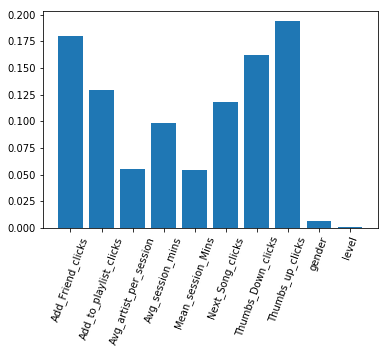

In [143]:
feature_importances = cv_fit.bestModel.stages[0].featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': input_cols[0:10]})
plt.bar(feature_importance_df['columns'], feature_importance_df['feature_importance'])
plt.xticks(rotation=70)

### As can be seen above the most important features is how many times a user clicks Thumbs up button, which is quite intuitive as this suggests that the user likes the songs suggested by the app, the second most important add friend clicks again indicative how much a user likes the experience of the application

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.